## 1 Загружаем данные и библиотеки

In [1374]:
#Библиотека с github для оценки фичей (установка)

!pip install git+https://github.com/WillKoehrsen/feature-selector.git

  Cloning https://github.com/WillKoehrsen/feature-selector.git to /tmp/pip-req-build-_pwk00m8
  Running command git clone -q https://github.com/WillKoehrsen/feature-selector.git /tmp/pip-req-build-_pwk00m8


In [1375]:
#Библиотека с github для оценки фичей (импорт)

from feature_selector import FeatureSelector

In [1376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [1377]:
#Загружаем данные
df_main = pd.read_csv('train_dataset_hackathon_mkb.csv', encoding='cp1251', sep=';')
X_test = pd.read_csv('test_dataset_hackathon_mkb.csv', encoding='cp1251', sep=';')

descrip = pd.read_excel('data_description.xlsx')

Сразу отредактируем main и X_test датасеты

###1.1 Проверим уникальность клиентов

#### 1.1.1 Train

In [1378]:
#Переведём дату регистрации в формат месяц-год

df_main['SIGN_DATE'] = pd.to_datetime(df_main['SIGN_DATE'], format='%d%b%Y:%H:%M:%S')
df_main['SIGN_DATE'] = df_main['SIGN_DATE'].apply(lambda x: x.strftime('%B-%Y'))

X_test['SIGN_DATE'] = pd.to_datetime(X_test['SIGN_DATE'], format='%d%b%Y:%H:%M:%S')
X_test['SIGN_DATE'] = X_test['SIGN_DATE'].apply(lambda x: x.strftime('%B-%Y'))

In [1379]:
client_enters_train = pd.DataFrame()
client_enters_train['client_enters'] = df_main.groupby('id_client').count()['SIGN_DATE'].sort_values(ascending=False)

In [1380]:
#Добавим новый признак по количеству вхождений клиента

df_main = df_main.merge(client_enters_train, on='id_client', how='left')

In [1381]:
#Фичи для проверки уникальности

index_dupl = df_main.iloc[1, 2:].index.to_list()

In [1382]:
index_dupl.append('id_client')

In [1383]:
#Убираем все повторяющиеся строки

df_main = df_main.drop_duplicates(index_dupl, keep='first')

In [1384]:
#Уникальные клиенты

len(pd.unique(df_main.id_client))

8922

In [1385]:
client_enters_train_new = pd.DataFrame()
client_enters_train_new['client_enters'] = df_main.groupby('id_client').count()['SIGN_DATE'].sort_values(ascending=False)
client_enters_train_new

,client_enters
id_client,
10845,26
10399,23
11257,20
10092,18
10714,17
...,...
8073,1
8074,1
8075,1


Убираем большое количество повторяющихся элементов. Оставшееся элементы повторяющиеся по id_client являются уникальными.

In [1386]:
#Сбрасываем индексы
df_main = df_main.reset_index()

#### 1.1.2 test

In [1387]:
client_enters_test = pd.DataFrame()
client_enters_test['client_enters'] = X_test.groupby('id_client').count()['SIGN_DATE'].sort_values(ascending=False)

In [1388]:
#Добавим новый признак по количеству вхождений клиента

X_test = X_test.merge(client_enters_test, on='id_client', how='left')

In [1389]:
# del index_dupl[2]

In [1390]:
#Убираем все повторяющиеся строки

# X_test = X_test.drop_duplicates(index_dupl, keep='first')

In [1391]:
# len(pd.unique(X_test.id_client))

In [1392]:
# client_enters_test_new = pd.DataFrame()
# client_enters_test_new['client_enters'] = X_test.groupby('id_client').count()['SIGN_DATE'].sort_values(ascending=False)
# client_enters_test_new

Имеется большое количество повторяющихся клиентов, которые имееют одинаковый набор признаков. В таком случае удаляем все повторяющиеся элементы.

In [1393]:
# #Сбрасываем индексы
# X_test = X_test.reset_index()

In [1394]:
#Удалим столбец index из X

df_main = df_main.drop('index', axis=1)
# X_test = X_test.drop('index', axis=1)

### 1.2 Найдём неинформативные признаки (mute)

In [1395]:
# #Создадим список с высоким процентным содержанием неинформативных данных

# num_rows = len(df_main.index)
# low_information_cols = [] #

# for col in df_main.columns:
#     cnts = df_main[col].value_counts(dropna=False)
#     top_pct = (cnts/num_rows).iloc[0]
    
#     if top_pct > 0.94:
#         low_information_cols.append(col)
#         print('{0}: {1:.5f}%'.format(col, top_pct*100))
#         print(cnts.iloc[:1], '\n')

Во всех случаях большенство занимает одно и тоже пропущенное значение. Я считаю, что эти значения не несут никакой полезной информации и будут удалены из train и из test.

In [1396]:
# num_rows_test = len(X_test.index)
# low_information_cols_test = []

# for col in X_test.columns:
#     cnts = X_test[col].value_counts(dropna=False)
#     top_pct = (cnts/num_rows_test).iloc[0]
    
#     if top_pct > 0.94:
#         low_information_cols_test.append(col)

In [1397]:
# df_main = df_main.drop(low_information_cols, axis=1)
# X_test = X_test.drop(low_information_cols, axis=1)

### 1.3 Удалим ненужные признаки (mute)

Многие признаки коррелируют между собой. В Этом разделе удалим признаки которые показывают действия клиента за последний год и оставим только за весь период.

In [1398]:
# del_columns_year = list(descrip.iloc[[87, 88, 89, 90, 91, 97, 98, 99, 100, 101, 107, 108, 109, 110, 111], 0])

In [1399]:
# df_main = df_main.drop(del_columns_year, axis=1)
# X_test = X_test.drop(del_columns_year, axis=1)

### 1.4 Делим датасет на основной (X) и Target (y)

In [1400]:
#Отделяем целевой признак от основного датасета
y = df_main.TARGET
X = df_main.drop('TARGET', axis=1)

In [1401]:
#Общий вид датасета

X.head(5)

,id_contract,id_client,SIGN_DATE,IP_flag,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,...,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME,client_enters
0,1,1847,January-2018,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,1.083075e+09,...,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
1,2,4650,January-2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,4770,January-2018,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,NaN,...,1.0,36.00.2,6.0,2762852.0,1.0,794.0,3.0,21.0,5408695.0,39.0,882647.0,4.0,1.0,0.0,1.0,1.0,1174998.0,2.0,0.0,2.0,2.0,2738217.0,38.0,0.0,38.0,39.0,4209963.0,169.0,0.0,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2
3,4,12237,January-2018,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,356828000.0,38078000.0,5.786965e+09,12001000.0,71000.0,1.232486e+09,78603000.0,4.459193e+09,4611000.0,2.685905e+09,1.516514e+09,NaN,NaN,65834000.0,1.103557e+09,627253000.0,NaN,689000.0,626564000.0,4.411295e+09,3.930000e+05,3.092581e+09,NaN,NaN,7.724453e+09,7.724453e+09,1.694054e+10,4.028466e+10,2.334412e+10,931118000.0,1.600942e+10,...,1.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
4,5,9988,January-2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [1402]:
#Описание признаков
descrip.style

,Название поля,Описание
0,id_contract,Идентификатор контракта
1,id_client,Идентификатор клиента
2,SIGN_DATE,Дата подписания контракта
3,IP_flag,Флаг ИП
4,TARGET,Целевая переменная - факт наличия предъявления по гарантии
5,F1100,Внеоборотные активы
6,F1110,Нематериальные активы
7,F1150,Основные средства
8,F1160,Доходные вложения в материальные ценности
9,F1170,Долгосрочные финансовые вложения


### 1.5 Feature Selector

Библиотека feature Selector разработа и находиться в открытом доступе на github.com. Необходима для эффективной работе с признаками.

In [1403]:
fs = FeatureSelector(data=X, labels=y)

Найдём неинформативные признаки с большим количеством пропущенных значений.

In [1404]:
#Пропущенные значения (порог установим в 94% пропущенных значений)

fs.identify_missing(missing_threshold=0.94)
fs.missing_stats.head(8)

8 features with greater than 0.94 missing values.



,missing_fraction
FLAG_DISQUALIFICATION,0.999673
F1320,0.994440
COUNT_CHANGE_YEAR,0.991497
F1160,0.982994
F2310,0.981931
F1450,0.952498
F1530,0.946938
F1550,0.944976


In [1405]:
#Список пропущенных значений с порогом 94%

missing_features = fs.ops['missing']

Посмотрим на корреляцию признаков.

110 features with a correlation magnitude greater than 0.00.



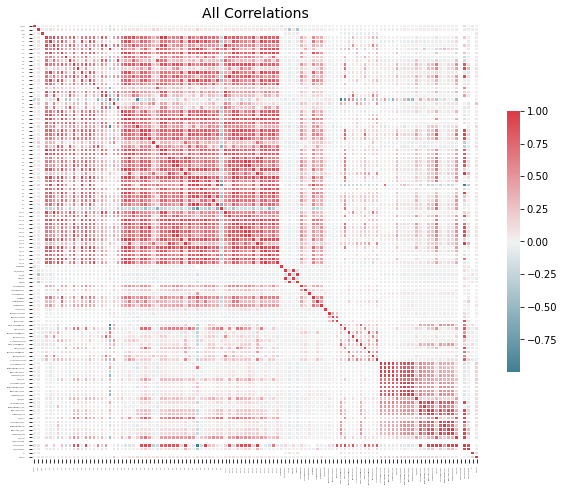

In [1406]:
#Корреляция всех признаков
fs.identify_collinear(correlation_threshold=0)

fs.plot_collinear(plot_all=True)

Видны целые группы признаков сильно коррелирующих между собой. Установим порог корреляции в 80% и определим эти признаки.

In [1407]:
#Корреляция признаков с порогом 80%

fs.identify_collinear(correlation_threshold=0.8)

71 features with a correlation magnitude greater than 0.80.



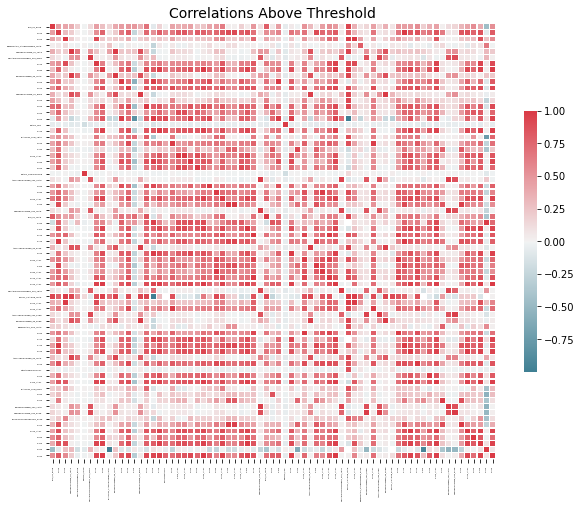

In [1408]:
#Heatmap корреляции признаков (коеф корреляции = 0.8)

fs.plot_collinear()

In [1409]:
#Список коррелирующих признаков
collinear_features = fs.ops['collinear']

#Датасет коррелирующих признаков
fs.record_collinear.head(5)

,drop_feature,corr_feature,corr_value
0,F1150,F1100,0.919884
1,F1170,F1110,0.880752
2,F1200,F1100,0.810560
3,F1220,F1110,0.941792
4,F1220,F1170,0.888626


Найдём признаки с нулевой важностью (Но не будем их исключать из общего датасета). Просто для информации.

In [1410]:
# #Для этого используем только цифровые признаки
# X_num = X.drop(X.select_dtypes('object').columns, axis=1)

# fs = FeatureSelector(data=X_num, labels=y)

# fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', n_iterations = 5, early_stopping = True)

# zero_importance_features = fs.ops['zero_importance']

# fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [1411]:
len(collinear_features), len(missing_features)

(71, 8)

In [1412]:
#Удалим повторяющиеся значения в обоих списках (если таковые имеются)

drop_feature_list = set(collinear_features + missing_features)
drop_feature_list = list(drop_feature_list)

In [1413]:
#Таким образом удалим все неинформативные и коррелирующие между собой признаки

X = X.drop(drop_feature_list, axis=1)
X_test = X_test.drop(drop_feature_list, axis=1)

In [1414]:
#Размерности датасетов

X.shape, y.shape, X_test.shape

((12231, 50), (12231,), (7330, 50))



---


## 2 Предварительный анализ и обработка

### 2.1 Наличие пропущенных значений

In [1415]:
#Смотрим на количество пропущенных значений

pd.concat([X.isnull().sum().rename('train'), X_test.isnull().sum().rename('test')], axis=1)\
.sort_values(['train', 'test'], ascending=False).style

,train,test
F1350,11425,7071
F1110,11301,6872
BIRTHDATE,11164,6715
AGE,11164,6715
F1190,11038,6872
CITIZENSHIP_NAME,10799,5899
SEX_NAME,10762,5896
F1180,10538,6651
PLAINTIFF_SUM_YEAR,9847,5864
DEFENDANT_CASESNUMBER_YEAR,9847,5864


Имеется большое количество пропущенных значений как в train, так и в test датасете (стоит помнить, что количество объектов в test датасете меньше чем в train).

###2.2 Визуализируем распределение признаков

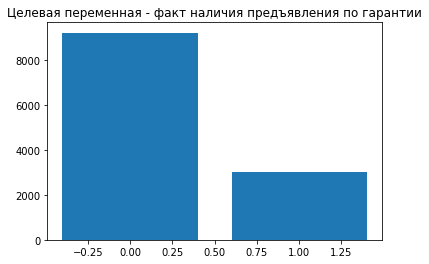

In [1416]:
#Посмотрим распределения целевого признака
plt.bar(df_main.groupby('TARGET').count().index, df_main.groupby('TARGET').count().iloc[:, 0])
plt.title(descrip[descrip['Название поля'] == 'TARGET']['Описание'].values[0])

plt.show()

Следует отметить, что датасет несбалансирован. В дальнейшем это будет учтено.

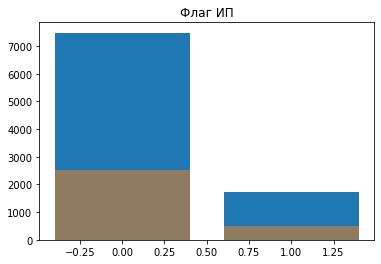

In [1417]:
#Посмотрим распределения ИП
plt.bar(df_main[df_main.TARGET == 0].groupby('IP_flag').count().index, df_main[df_main.TARGET == 0].groupby('IP_flag').count().iloc[:, 0])
plt.bar(df_main[df_main.TARGET == 1].groupby('IP_flag').count().index, df_main[df_main.TARGET == 1].groupby('IP_flag').count().iloc[:, 0], alpha=0.5)

plt.title(descrip[descrip['Название поля'] == 'IP_flag']['Описание'].values[0])

plt.show()

In [1418]:
#Переведём столбцы с датой в тип datetime

X['DATEFIRSTREG'] = pd.to_datetime(X['DATEFIRSTREG'], format='%d%b%Y:%H:%M:%S')
X['TAXREG_REGDATE'] = pd.to_datetime(X['TAXREG_REGDATE'], format='%d%b%Y:%H:%M:%S')
X['TAXREGPAY_REGDATE'] = pd.to_datetime(X['TAXREGPAY_REGDATE'], format='%d%b%Y:%H:%M:%S')
X['BIRTHDATE'] = pd.to_datetime(X['BIRTHDATE'], format='%d%b%Y:%H:%M:%S')

X_test['DATEFIRSTREG'] = pd.to_datetime(X_test['DATEFIRSTREG'], format='%d%b%Y:%H:%M:%S')
X_test['TAXREG_REGDATE'] = pd.to_datetime(X_test['TAXREG_REGDATE'], format='%d%b%Y:%H:%M:%S')
X_test['TAXREGPAY_REGDATE'] = pd.to_datetime(X_test['TAXREGPAY_REGDATE'], format='%d%b%Y:%H:%M:%S')
X_test['BIRTHDATE'] = pd.to_datetime(X_test['BIRTHDATE'], format='%d%b%Y:%H:%M:%S')

In [1419]:
#Отделим цифровые и не цифровые признаки,а также datetime
columns_num = X.select_dtypes(exclude=['object', 'datetime64[ns]']).columns
columns_obj = X.select_dtypes('object').columns
columns_date = X.select_dtypes('datetime64[ns]').columns

len(columns_num), len(columns_obj), len(columns_date)

(38, 8, 4)

In [1420]:
#Отделим часть цифровых признаков для подробной визуализации
columns_num_1 = ['OKATO_REGIONCODE', 'OKATO_FED', 'AGE']

In [1421]:
#Уберём из общего числа цифровых признаков не нужные признаки

columns_num = columns_num.drop(columns_num_1)
columns_num = columns_num.drop(['id_contract', 'id_client', 'IP_flag'])

In [1422]:
#Уберём из общего числа не цифровых признаков не нужные признаки

columns_obj = columns_obj.drop('OKVED_CODE')
columns_obj = columns_obj.drop('SIGN_DATE')

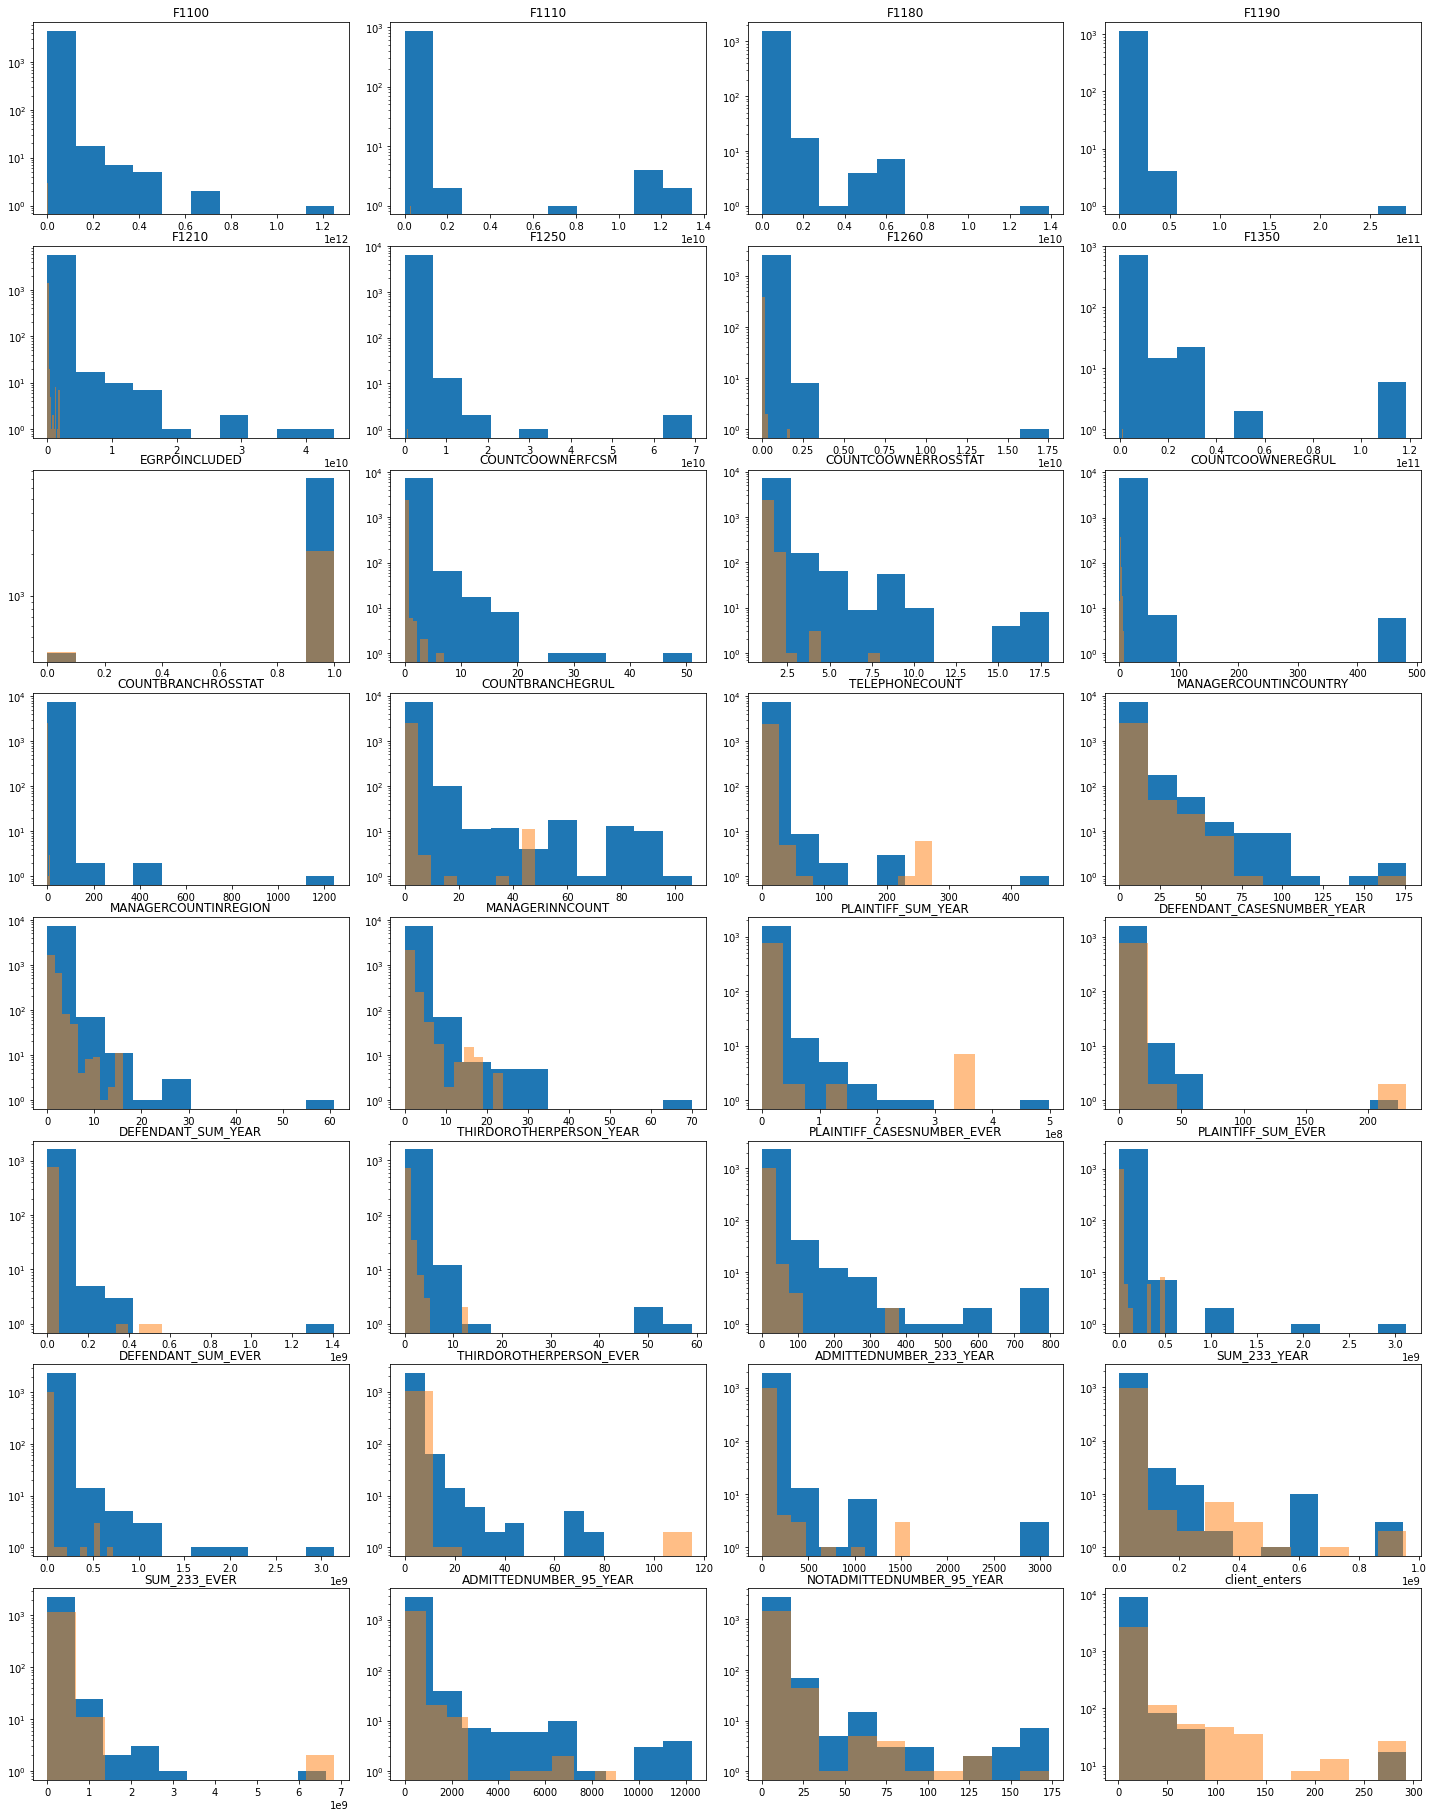

In [1423]:
# Визуализируем распределение цифровых признаков
fig, axs = plt.subplots(ncols=4, nrows=8, figsize=(20, 25))
plt.tight_layout() 

for i in range(8):
  for j in range(4):
    axs[i][j].hist(df_main[df_main.TARGET == 0][columns_num[i*4+j]], log=True)
    axs[i][j].hist(df_main[df_main.TARGET == 1][columns_num[i*4+j]], log=True, alpha=0.5)

    axs[i][j].set_title(columns_num[i*4+j])

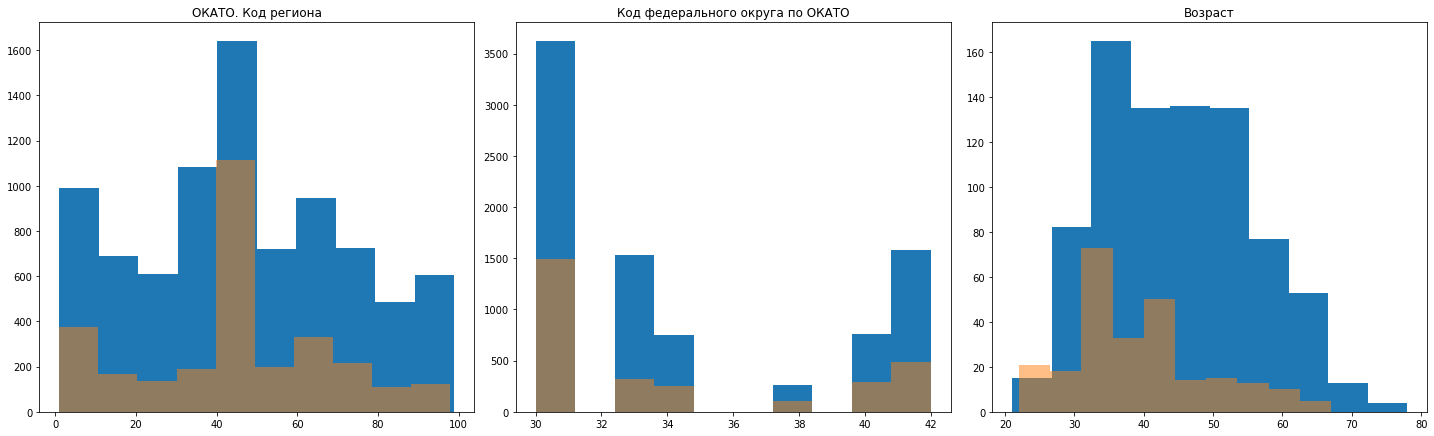

In [1424]:
#Визуализируем 3 признака более подробно

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
plt.tight_layout() 

for i in range(3):
  axs[i].hist(df_main[df_main.TARGET == 0][columns_num_1[i]])
  axs[i].hist(df_main[df_main.TARGET == 1][columns_num_1[i]], alpha=0.5)
  axs[i].set_title(descrip[descrip['Название поля'] == columns_num_1[i]]['Описание'].values[0])

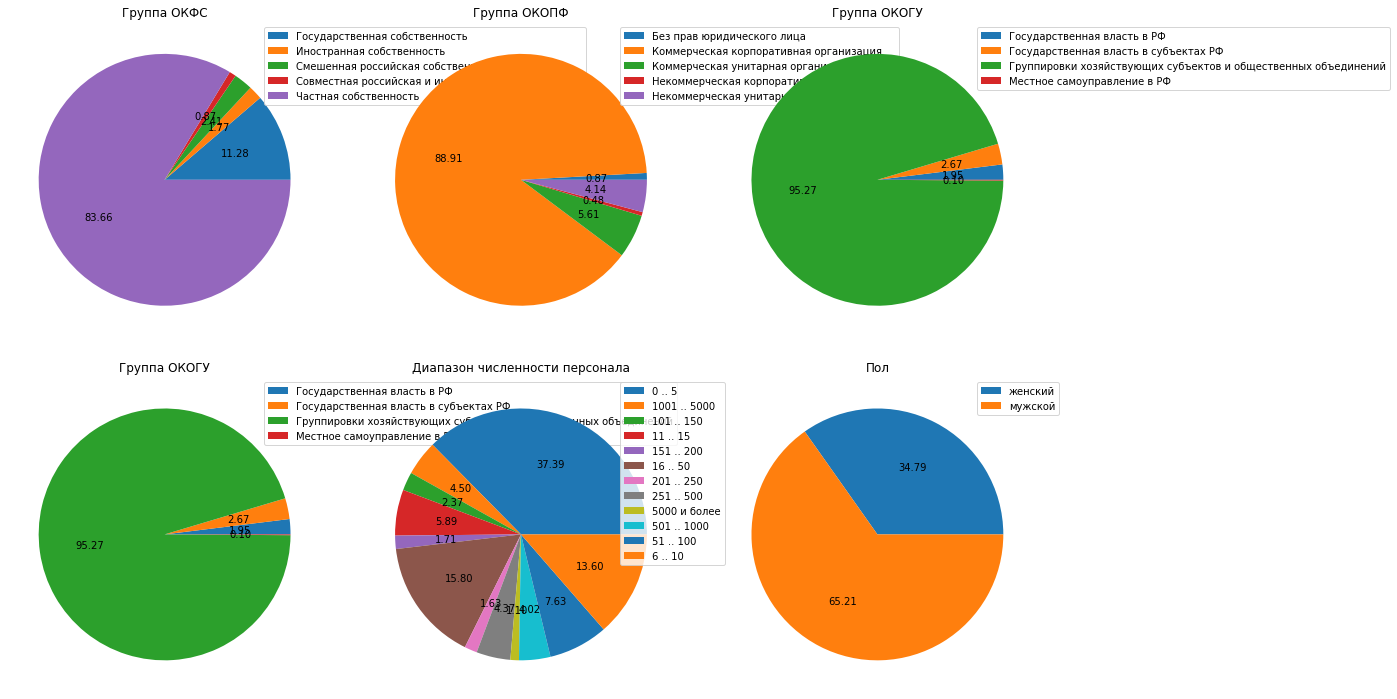

In [1425]:
# Визуализируем распределение не цифровых признаков
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
plt.tight_layout() 

for i in range(2):
  for j in range(3):
    axs[i][j].pie(X.groupby(columns_obj[i*2+j]).count()['id_client'], autopct='%.2f')
    axs[i][j].legend(labels=X.groupby(columns_obj[i*2+j]).count().index, loc='upper left', bbox_to_anchor=(0.8, 1))
    axs[i][j].set_title(descrip[descrip['Название поля'] == columns_obj[i*2+j]]['Описание'].values[0])

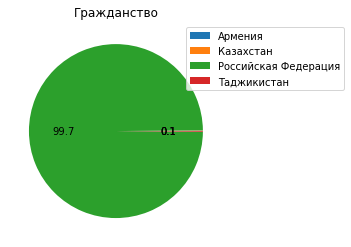

In [1426]:
#Отдельно визуализируем гражданство

plt.pie(X.groupby(columns_obj[-1]).count()['id_client'], autopct='%.1f')
plt.legend(labels=X.groupby(columns_obj[-1]).count().index, loc='upper left', bbox_to_anchor=(0.8, 1))
plt.title(descrip[descrip['Название поля'] == columns_obj[-1]]['Описание'].values[0])

plt.show()

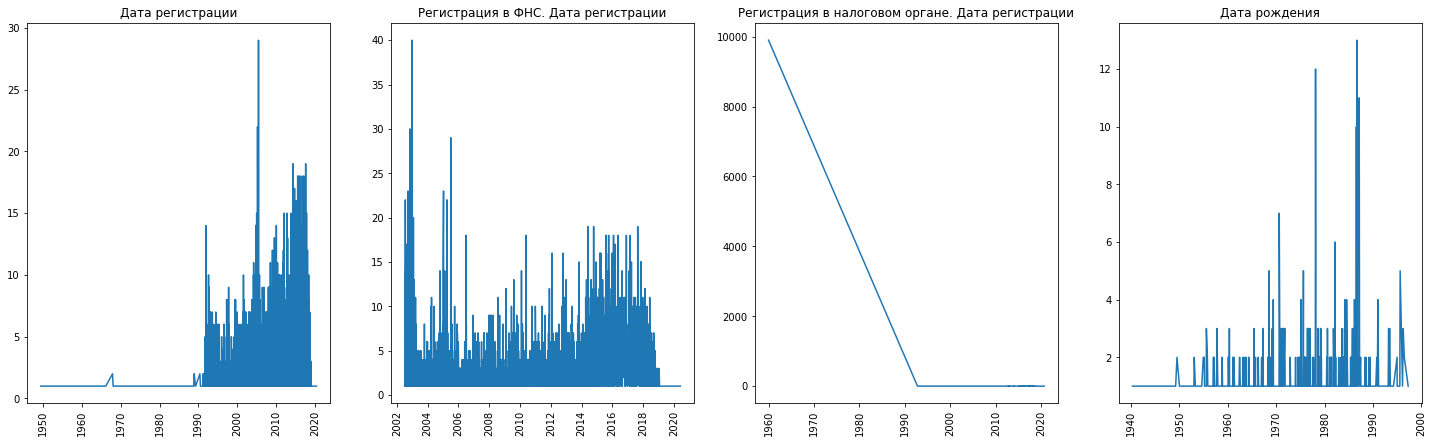

In [1427]:
# #Визуализируем по дате
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(25, 7))

for i in range(4):
  axs[i].plot(X.groupby(columns_date[i]).count()['id_client'])
  axs[i].set_title(descrip[descrip['Название поля'] == columns_date[i]]['Описание'].values[0])
  axs[i].tick_params(axis='x', labelrotation=90)
plt.show()



---



## 3 Отредактируем признаки

### 3.1 Переведём не цифровые признаки в цифровые

OKVED_CODE

In [1428]:
#Создадим словари значений для OKVED_CODE

OKVED_CODE_dict = {j:i for i, j in enumerate(pd.unique(X['OKVED_CODE']))}
OKVED_CODE_dict_test = {j:i for i, j in enumerate(pd.unique(X_test['OKVED_CODE']))}

OKVED_CODE_dict = list(OKVED_CODE_dict.keys())
OKVED_CODE_dict_test = list(OKVED_CODE_dict_test.keys())

OKVED_CODE_dict_train_test = set(OKVED_CODE_dict + OKVED_CODE_dict_test)

In [1429]:
OKVED_CODE_dict_train_test = {j:i for i, j in enumerate(OKVED_CODE_dict_train_test)}

In [1430]:
# Заменим не цифровые значения

X['OKVED_CODE'] = X['OKVED_CODE'].map(OKVED_CODE_dict_train_test)
X_test['OKVED_CODE'] = X_test['OKVED_CODE'].map(OKVED_CODE_dict_train_test)

Остальные признаки

In [1431]:
#Создадим словари значений

for i in range(len(columns_obj)):
  values_list = pd.unique(X[columns_obj[i]])

  if i<4:
    locals()[columns_obj[i] + str('_dict')] = {j:i for i, j in enumerate(values_list[1:])}
    locals()[columns_obj[i] + str('_dict')][values_list[0]] = len(values_list)-1
  else:
    locals()[columns_obj[i] + str('_dict')] = {j:i for i, j in enumerate(values_list[:])}

In [1432]:
# # Словари значений

# OKFS_GROUP_dict
# OKOPF_GROUP_dict
# OKOGU_GROUP_dict
# WORKERSRANGE_dict
# SEX_NAME_dict
# CITIZENSHIP_NAME_dict

In [1433]:
OKFS_GROUP_dict[list(OKFS_GROUP_dict.keys())[0]] = 5

OKOPF_GROUP_dict[list(OKOPF_GROUP_dict.keys())[0]] = 5

# OKOGU_GROUP_dict[list(OKOGU_GROUP_dict.keys())[0]] = 4

In [1434]:
WORKERSRANGE_dict[list(WORKERSRANGE_dict.keys())[0]] = 6

In [1435]:
# Заменим не цифровые значения
for i in range(len(columns_obj)):
  X[columns_obj[i]] = X[columns_obj[i]].map(locals()[columns_obj[i] + str('_dict')])

for i in range(len(columns_obj)):
  X_test[columns_obj[i]] = X_test[columns_obj[i]].map(locals()[columns_obj[i] + str('_dict')])

In [1436]:
#Посмотрим на корреляцию не цифровых признаков с целевым признаком

X[columns_obj].corrwith(y).sort_values(ascending=False).to_frame().style.bar(align='zero', vmax=1)

,0
WORKERSRANGE,0.223389
OKFS_GROUP,0.171896
OKOPF_GROUP,0.149829
OKOGU_GROUP,0.051721
CITIZENSHIP_NAME,0.050664
SEX_NAME,0.047250


Видна слабая корреляция признаков

### 3.2 Объединим некоторые признаки (mute)

Изменим данные по средствам за текущий и предыдущий период. На их основе создадим новые признаки по изменению сдреств с прошлого периода.

In [1437]:
# finance_change_columns = ['F1150_chg', 'F1230_chg', 'F1410_chg', 'F1510_chg', 'F1520_chg', 'F2110_chg', 'F2120_chg', 'F2200_chg', 
#                           'F2210_chg', 'F2220_chg', 'F2300_chg', 'F2320_chg', 'F2330_chg', 'F2400_chg']

In [1438]:
# current_period_test = X_test.loc[:, ['F1150', 'F1230', 'F1410','F1510','F1520','F2110',
#                                      'F2120','F2200','F2210','F2220','F2300','F2320','F2330','F2400',]]

# last_period_test = X_test.loc[:, ['F1150_LAG1', 'F1230_LAG1', 'F1410_LAG1','F1510_LAG1','F1520_LAG1','F2110_LAG1','F2120_LAG1',
#                                   'F2200_LAG1','F2210_LAG1','F2220_LAG1','F2300_LAG1','F2320_LAG1','F2330_LAG1','F2400_LAG1',]]

In [1439]:
# #Посчитаем разницу за прошлый и текущий период для train и test

# finance_change = pd.DataFrame(current_period.values - last_period.values, columns=current_period.columns, index=current_period.index)
# finance_change_test = pd.DataFrame(current_period_test.values - last_period_test.values, columns=current_period_test.columns, index=current_period_test.index)

In [1440]:
# #Изменим название столбцов

# finance_change.columns = finance_change_columns
# finance_change_test.columns = finance_change_columns

In [1441]:
# #Добавляем разницу в наши датасеты и удаляем ненужные признаки

# X = X.merge(finance_change, left_index=True, right_index=True, how='left')
# X = X.drop(current_period.columns, axis=1)
# X = X.drop(last_period.columns, axis=1)

# X_test = X_test.merge(finance_change_test, left_index=True, right_index=True, how='left')
# X_test = X_test.drop(current_period_test.columns, axis=1)
# X_test = X_test.drop(last_period_test.columns, axis=1)

In [1442]:
# #Добавим эти признаки в df_main для визуализации с TARGET

# df_main = df_main.merge(finance_change, left_index=True, right_index=True, how='left')

In [1443]:
# #Визуализируем распределение по признакам finance_change_columns
# fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(22, 9))
# plt.tight_layout() 

# for i in range(2):
#   for j in range(7):
#     axs[i][j].hist(df_main[df_main.TARGET == 0][finance_change_columns[i*7+j]], log=True)
#     axs[i][j].hist(df_main[df_main.TARGET == 1][finance_change_columns[i*7+j]], log=True, alpha=0.5)

#     axs[i][j].set_title(finance_change_columns[i*7+j])

### 3.3 Переведём даты в цифровой формат

In [1444]:
#Текущая дата

current_date = dt.datetime.today()

In [1445]:
X['SIGN_DATE'] = pd.to_datetime(X['SIGN_DATE'], format='%B-%Y')
X_test['SIGN_DATE'] = pd.to_datetime(X_test['SIGN_DATE'], format='%B-%Y')

In [1446]:
#Посчитаем количество дней для каждой даты в train 

X['SIGN_DATE'] = (current_date - X['SIGN_DATE']).apply(lambda x: x.days)
X['DATEFIRSTREG'] = (current_date - X['DATEFIRSTREG']).apply(lambda x: x.days)
X['TAXREG_REGDATE'] = (current_date - X['TAXREG_REGDATE']).apply(lambda x: x.days)
X['TAXREGPAY_REGDATE'] = (current_date - X['TAXREGPAY_REGDATE']).apply(lambda x: x.days)

In [1447]:
#Посчитаем количество дней для каждой даты в test

X_test['SIGN_DATE'] = (current_date - X_test['SIGN_DATE']).apply(lambda x: x.days)
X_test['DATEFIRSTREG'] = (current_date - X_test['DATEFIRSTREG']).apply(lambda x: x.days)
X_test['TAXREG_REGDATE'] = (current_date - X_test['TAXREG_REGDATE']).apply(lambda x: x.days)
X_test['TAXREGPAY_REGDATE'] = (current_date - X_test['TAXREGPAY_REGDATE']).apply(lambda x: x.days)

### 3.4 Очистим пропущенные значения

#### 3.3.1 train

In [1448]:
F_null_columns = ['F1100', 'F1110', 'F1180', 'F1190', 'F1210', 'F1250', 'F1260', 'F1350']

EGRPOIN_null_columns = ['EGRPOINCLUDED']

date_null_columns = ['DATEFIRSTREG', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE']

OKATO_null_columns = ['OKATO_REGIONCODE', 'OKATO_FED']

COUNT_null_columns = ['COUNTCOOWNERFCSM', 'COUNTCOOWNERROSSTAT', 'COUNTCOOWNEREGRUL', 'COUNTBRANCHROSSTAT', 'COUNTBRANCHEGRUL']

TEL_MANAGER_null_columns = ['TELEPHONECOUNT', 'MANAGERCOUNTINCOUNTRY', 'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT']

finance_null_columns = ['PLAINTIFF_SUM_YEAR', 'DEFENDANT_CASESNUMBER_YEAR', 'DEFENDANT_SUM_YEAR', 
                        'THIRDOROTHERPERSON_YEAR', 'PLAINTIFF_CASESNUMBER_EVER','PLAINTIFF_SUM_EVER', 
                        'DEFENDANT_SUM_EVER', 'THIRDOROTHERPERSON_EVER', 'ADMITTEDNUMBER_233_YEAR', 
                        'SUM_233_YEAR', 'SUM_233_EVER', 'ADMITTEDNUMBER_95_YEAR', 'NOTADMITTEDNUMBER_95_YEAR',]

In [1449]:
for i in range(len(F_null_columns)):
  X[F_null_columns[i]] = X[F_null_columns[i]].fillna(0)

for i in range(len(EGRPOIN_null_columns)):
  X[EGRPOIN_null_columns[i]] = X[EGRPOIN_null_columns[i]].fillna(1)

for i in range(len(date_null_columns)):
  X[date_null_columns[i]] = X[date_null_columns[i]].fillna(X[date_null_columns[i]].min())

for i in range(len(OKATO_null_columns)):
  X[OKATO_null_columns[i]] = X[OKATO_null_columns[i]].fillna(X[OKATO_null_columns[i]].value_counts().index[0])

for i in range(len(COUNT_null_columns)):
  X[COUNT_null_columns[i]] = X[COUNT_null_columns[i]].fillna(0)

for i in range(len(TEL_MANAGER_null_columns)):
  X[TEL_MANAGER_null_columns[i]] = X[TEL_MANAGER_null_columns[i]].fillna(0)

for i in range(len(finance_null_columns)):
  X[finance_null_columns[i]] = X[finance_null_columns[i]].fillna(0)


X['AGE'] = X['AGE'].fillna(round(X['AGE'].mean(), 0))

Оставшиеся пропущенные значения

In [1450]:
null_columns = list(X.columns[(X.isnull().sum() > 0)])
len(null_columns)

1

Удалим ненужные столбцы

In [1451]:
X = X.drop('BIRTHDATE', axis=1)
# X = X.drop('OKVED_CODE', axis=1)

#### 3.3.2 test

In [1452]:
for i in range(len(F_null_columns)):
  X_test[F_null_columns[i]] = X_test[F_null_columns[i]].fillna(0)

for i in range(len(EGRPOIN_null_columns)):
  X_test[EGRPOIN_null_columns[i]] = X_test[EGRPOIN_null_columns[i]].fillna(1)

for i in range(len(date_null_columns)):
  X_test[date_null_columns[i]] = X_test[date_null_columns[i]].fillna(X_test[date_null_columns[i]].min())

for i in range(len(OKATO_null_columns)):
  X_test[OKATO_null_columns[i]] = X_test[OKATO_null_columns[i]].fillna(X_test[OKATO_null_columns[i]].value_counts().index[0])

for i in range(len(COUNT_null_columns)):
  X_test[COUNT_null_columns[i]] = X_test[COUNT_null_columns[i]].fillna(0)

for i in range(len(TEL_MANAGER_null_columns)):
  X_test[TEL_MANAGER_null_columns[i]] = X_test[TEL_MANAGER_null_columns[i]].fillna(0)

for i in range(len(finance_null_columns)):
  X_test[finance_null_columns[i]] = X_test[finance_null_columns[i]].fillna(0)


X_test['AGE'] = X_test['AGE'].fillna(round(X_test['AGE'].mean(), 0))

X_test['CITIZENSHIP_NAME'] = X_test['CITIZENSHIP_NAME'].fillna(1)

Остальные пропущенные значения

In [1453]:
null_columns_test = list(X_test.columns[(X_test.isnull().sum() > 0)])
len(null_columns_test)

1

Удалим ненужные столбцы

In [1454]:
X_test = X_test.drop('BIRTHDATE', axis=1)
# X_test = X_test.drop('OKVED_CODE', axis=1)

### 3.5 Кратное описание отредактированного датасета

Так выглядит наш обработанный датасет

In [1455]:
X.head()

,id_contract,id_client,SIGN_DATE,IP_flag,F1100,F1110,F1180,F1190,F1210,F1250,F1260,F1350,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,SUM_233_YEAR,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,AGE,SEX_NAME,CITIZENSHIP_NAME,client_enters
0,1,1847,1418,0,1.298961e+09,2154000.0,0.0,21224000.0,105901000.0,3.312980e+08,138000.0,599497000.0,1.0,10328.0,5,5,4,3.0,40.0,12,5620.0,22603.0,5.0,1.0,0.0,7.0,7.0,3.0,0.0,0.0,0.0,363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0,0,17
1,2,4650,1418,1,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,535.0,5,5,0,45.0,30.0,6,535.0,450.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0,0,1
2,3,4770,1418,0,7.337400e+07,0.0,0.0,0.0,2378000.0,5.530000e+05,37000.0,6780000.0,1.0,10881.0,1,1,4,33.0,33.0,1,7021.0,22603.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,540,2762852.0,1.0,794.0,3.0,21.0,5408695.0,882647.0,4.0,1.0,1174998.0,2738217.0,38.0,0.0,43.0,0,0,2
3,4,12237,1418,0,1.937488e+09,122828000.0,356828000.0,38078000.0,12001000.0,4.459193e+09,4611000.0,0.0,1.0,5985.0,5,5,4,71.0,34.0,2,5985.0,22603.0,1.0,1.0,1.0,0.0,2.0,8.0,1.0,1.0,1.0,363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0,0,13
4,5,9988,1418,1,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,535.0,5,5,0,45.0,30.0,6,535.0,450.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0,0,1


In [1456]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12231 entries, 0 to 12230
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_contract                 12231 non-null  int64  
 1   id_client                   12231 non-null  int64  
 2   SIGN_DATE                   12231 non-null  int64  
 3   IP_flag                     12231 non-null  int64  
 4   F1100                       12231 non-null  float64
 5   F1110                       12231 non-null  float64
 6   F1180                       12231 non-null  float64
 7   F1190                       12231 non-null  float64
 8   F1210                       12231 non-null  float64
 9   F1250                       12231 non-null  float64
 10  F1260                       12231 non-null  float64
 11  F1350                       12231 non-null  float64
 12  EGRPOINCLUDED               12231 non-null  float64
 13  DATEFIRSTREG                122

In [1457]:
#Проверяем пропущенные значения

sum(X.isnull().sum() > 0)

0

In [1458]:
X_test.head()

,id_contract,id_client,SIGN_DATE,IP_flag,F1100,F1110,F1180,F1190,F1210,F1250,F1260,F1350,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,SUM_233_YEAR,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,AGE,SEX_NAME,CITIZENSHIP_NAME,client_enters
0,17892,3620,963,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,760.0,5,5,0,45.0,30.0,6,760.0,437.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0,0.0,5
1,17893,4101,963,0,1906000.0,0.0,0.0,0.0,4392000.0,9719000.0,0.0,0.0,1.0,4280.0,5,5,4,24.0,30.0,5,4280.0,22603.0,0.0,1.0,1.0,0.0,0.0,5.0,2.0,2.0,2.0,644,0.0,0.0,0.0,0.0,7.0,4726558.0,0.0,0.0,181.0,17883526.0,169299901.0,1204.0,2.0,43.0,0,0.0,1
2,17894,9589,963,0,147000.0,0.0,0.0,0.0,29812000.0,8430000.0,238000.0,0.0,1.0,8439.0,5,5,4,75.0,34.0,5,6900.0,22603.0,0.0,1.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0,397,2272145.0,2.0,176875.0,0.0,103.0,27542049.0,1743130.0,2.0,31.0,3681170.0,46085424.0,36.0,10.0,43.0,0,0.0,1
3,17895,11546,963,0,0.0,0.0,0.0,0.0,304000.0,920000.0,0.0,0.0,1.0,1597.0,5,5,4,40.0,31.0,10,1597.0,22603.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,43.0,0,0.0,1
4,17896,12558,963,0,26000.0,0.0,0.0,0.0,1324000.0,1000.0,0.0,0.0,1.0,2580.0,5,5,4,67.0,40.0,10,2580.0,22603.0,0.0,2.0,2.0,0.0,0.0,1.0,3.0,2.0,2.0,529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0,0.0,2


In [1459]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7330 entries, 0 to 7329
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_contract                 7330 non-null   int64  
 1   id_client                   7330 non-null   int64  
 2   SIGN_DATE                   7330 non-null   int64  
 3   IP_flag                     7330 non-null   int64  
 4   F1100                       7330 non-null   float64
 5   F1110                       7330 non-null   float64
 6   F1180                       7330 non-null   float64
 7   F1190                       7330 non-null   float64
 8   F1210                       7330 non-null   float64
 9   F1250                       7330 non-null   float64
 10  F1260                       7330 non-null   float64
 11  F1350                       7330 non-null   float64
 12  EGRPOINCLUDED               7330 non-null   float64
 13  DATEFIRSTREG                7330 

In [1460]:
#Проверяем пропущенные значения

sum(X_test.isnull().sum() > 0)

0



---



## 4 Построение модели

Мы определили, что имеющийся датасет несбалансирован. При очень большом соотношении доминирующего класса к минорному можно применить методы борьбы с несбалансированными датасетами - undersampling и oversampling, либо метод SMOTE.

В нашем случае, мы не будем перебалансировать датасет, а просто учтём это при выборе метрик качества.Стоит отметить что точность (Precision) и полнота (recall) не зависят от соотношения размеров классов.

Далее будем смотреть на результаты работы моделей и их метрики качества, и редактировать данные.

### 4.1 Импортируем библиотеки

In [1461]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

import warnings

### 4.2 Делим датасет и строим модели

In [1462]:
# from sklearn.preprocessing import StandardScaler

In [1463]:
# ss = StandardScaler()
# X = ss.fit_transform(X)
# X_test = ss.transform(X_test)

In [1464]:
random_state = 7

In [1465]:
#Так как датасет несбалансированный, то задаем параметр stratify = целевой признак
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_state)

### 4.4 Строим модели

С помощью GridSearchCV найдём наилучшие параметры для каждой модели.

Были выбраны следующие модели машинного обучения:

1. K-ближайших соседей - хорошо подходит для бинарной классификации
2. Деревья решений - наиболее интерпретируемый алгоритм
3. Логистическая регрессия - хорошо подходит для бинарной классификации

In [1466]:
#Создадим функцию для нахождения наилучших параметров
def best_params(reg, parametrs, X, y, cv):
  grid = GridSearchCV(reg, parametrs, cv=cv, scoring='roc_auc')
  grid = grid.fit(X, y)
  return grid.best_params_

In [1467]:
#Алгоритм kNN
knn_parametrs = {'n_neighbors': range(1, 50)}

#Decision Trees
dtc_parametrs = {'max_depth': range(1, 15), 'min_samples_leaf': range(1, 10)}

#LogisticRegression
lr_parametrs = {'C': np.arange(0.1, 2.0, 0.1)}

#Для кросс-валидации
skf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)

In [1468]:
# #Подбираем лучшие параметры
# knn_best_parametrs = best_params(KNeighborsClassifier(), 
#                                  knn_parametrs, x_train, y_train, skf)

# dtc_best_parametrs = best_params(DecisionTreeClassifier(random_state = random_state),
#                                  dtc_parametrs, x_train, y_train, skf)

# lr_best_parametrs = best_params(LogisticRegression(random_state = random_state),
#                                  lr_parametrs, x_train, y_train, skf)

# #Здесь выскакивало предупреждение, я его скрыл
# warnings.filterwarnings('ignore')

In [1469]:
# #Алгоритм kNN
# knn_best_parametrs = {'n_neighbors': 9}
knn_best_parametrs = {'n_neighbors': 26}


# #Decision Trees
# dtc_best_parametrs = {'max_depth': 8, 'min_samples_leaf': 5}
dtc_best_parametrs = {'max_depth': 10, 'min_samples_leaf': 9}

# #LogisticRegression
# lr_best_parametrs = {'C': 1.9}
lr_best_parametrs = {'C': 0.4}

In [1470]:
#Посмотрим какие параметры оказались наилучшими
print('kNN\n', '-'*20, '\n', knn_best_parametrs, '\n')
print('Decision Trees\n', '-'*20, '\n', dtc_best_parametrs, '\n')
print('LogisticRegression\n', '-'*20, '\n', lr_best_parametrs, '\n')

kNN
 -------------------- 
 {'n_neighbors': 26} 

Decision Trees
 -------------------- 
 {'max_depth': 10, 'min_samples_leaf': 9} 

LogisticRegression
 -------------------- 
 {'C': 0.4} 



**Строим модели** (с учетом наилучших параметров)

In [1471]:
#Алгоритм kNN
knn = KNeighborsClassifier(**knn_best_parametrs)
knn_model = knn.fit(x_train, y_train)
knn_pred = knn_model.predict(x_test)

In [1472]:
#Decision Trees
dtc = DecisionTreeClassifier(**dtc_best_parametrs, random_state=random_state)
dtc_model = dtc.fit(x_train, y_train)
dtc_pred = dtc_model.predict(x_test)

In [1473]:
#LogisticRegression
lr = LogisticRegression(**lr_best_parametrs, random_state=random_state)
lr_model = lr.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)

#Здесь выскакивало предупреждение, я его скрыл
warnings.filterwarnings('ignore')



---



## 5 Сравниваем качество моделей

### 5.1 Импортируем библиотеки

In [1474]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

### 5.2 Проверяем качество моделей

In [1475]:
#Алгоритм kNN
knn_roc_auc = roc_auc_score(y_test, knn_pred)

#Decision Trees
dtc_roc_auc = roc_auc_score(y_test, dtc_pred)

#LogisticRegression
lr_roc_auc = roc_auc_score(y_test, lr_pred)

In [1476]:
print('Алгоритм kNN\n', '-'*30, '\n', f'ROC-AUC score равен {round(knn_roc_auc, 4)} \n \n' )
print('Алгоритм Decision Trees\n', '-'*30, '\n', f'ROC-AUC score равен {round(dtc_roc_auc, 4)} \n \n' )
print('Алгоритм LogisticRegression\n', '-'*30, '\n', f'ROC-AUC score равен {round(lr_roc_auc, 4)} \n \n' )

Алгоритм kNN
 ------------------------------ 
 ROC-AUC score равен 0.583 
 

Алгоритм Decision Trees
 ------------------------------ 
 ROC-AUC score равен 0.7367 
 

Алгоритм LogisticRegression
 ------------------------------ 
 ROC-AUC score равен 0.5048 
 



В результате видно, что интересующая нас метрика довольно низкая. Далее попробуем увеличить качество в соответствии с этой метрикой. Попробуем увеличить веса для экземпляров класса.

In [1477]:
#Создадим веса для экземпляров класса
class_weights = {0: 1, 1: 2}

In [1478]:
#Ещё раз построим модель DTC, но с параметром class_weights
dtc_weights = DecisionTreeClassifier(**dtc_best_parametrs, random_state=random_state, class_weight=class_weights)
dtc_model_weights = dtc_weights.fit(x_train, y_train)
dtc_pred_weights = dtc_model_weights.predict(x_test)

dtc_roc_auc_weights = roc_auc_score(y_test, dtc_pred_weights)

In [1479]:
print('Алгоритм DTC\n', '-'*30, '\n', f'ROC-AUC score равен {round(dtc_roc_auc_weights, 4)} \n' )

Алгоритм DTC
 ------------------------------ 
 ROC-AUC score равен 0.7521 



In [1480]:
#Создадим веса для экземпляров класса
class_weights_lr = {0: 1, 1: 3}

In [1481]:
#Ещё раз построим модель LogisticRegression, но с параметром class_weights
lr_weights = LogisticRegression(**lr_best_parametrs, random_state=random_state, class_weight=class_weights_lr)
lr_model_weights = lr_weights.fit(x_train, y_train)
lr_pred_weights = lr_model_weights.predict(x_test)

lr_pred_prob_weights = lr_model_weights.predict_proba(x_test)

lr_pred_45_percent = (lr_pred_prob_weights > 0.45).astype(int)[:,1]

lr_roc_auc_weights = roc_auc_score(y_test, lr_pred_45_percent)

In [1482]:
print('Алгоритм LogisticRegression\n', '-'*30, '\n', f'ROC-AUC score равен {round(lr_roc_auc_weights, 4)} \n' )

Алгоритм LogisticRegression
 ------------------------------ 
 ROC-AUC score равен 0.5905 





---



## 6 XGBoost

Теперь построим модель с помощью алгоритма xgboost.

In [1483]:
#Создадим объекты DMatrix для работы с xgboost
xgb_dtrain = xgb.DMatrix(np.array(x_train), np.array(y_train))
xgb_dtest = xgb.DMatrix(np.array(x_test), np.array(y_test))

#Зададим параметры xgboost из которых будем искать наилучшие
xgb_parametrs = {'learning_rate': (0.05, 0.10, 0.15, 0.20),  'max_depth': [1, 2, 3, 4, 5], 'n_estimators': range(50, 300, 50)}

#Количество итераций
num_rounds = 30

In [1484]:
# xgb_best_parametrs = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
# xgb_best_parametrs = {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 250}
# xgb_best_parametrs = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
xgb_best_parametrs = {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 250}

In [1485]:
#Подбираем лучшие параметры для xgboost
# xgb_best_parametrs = best_params(xgb.XGBClassifier(), xgb_parametrs, np.array(x_train), np.array(y_train), skf)

In [1486]:
#Посмотрим какие параметры оказались наилучшими
print('XGBoost best parametrs\n', '-'*20, '\n', xgb_best_parametrs, '\n')

XGBoost best parametrs
 -------------------- 
 {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 250} 



Далее будем задавать полученные, наилучшие параметры модели.

In [1487]:
#Создадим модель xgboost
xgb_model = xgb.train(xgb_best_parametrs, xgb_dtrain, num_rounds)

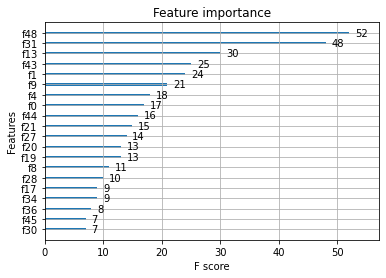

In [1488]:
#Посмотрим какие фичи модель выделила больше всего
xgb.plot_importance(xgb_model, max_num_features=20)

plt.show()

In [1489]:
#Создадим предсказание xgb модели
xgb_pred = xgb_model.predict(xgb_dtest)

Так как xgb predict возвращает вероятности, мы можем задать пороговое значение.

In [1490]:
#Зададим порог в 50%
xgb_pred_50_percent = (xgb_pred > 0.5).astype(int)

Проверим качество работы модели с помощью ROC AUC score

In [1491]:
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_50_percent)

In [1492]:
#Зададим порог в 45%
xgb_pred_45_percent = (xgb_pred > 0.45).astype(int)

In [1493]:
xgb_roc_auc_45 = roc_auc_score(y_test, xgb_pred_45_percent)

In [1494]:
print('Алгоритм XGBoost (порог 50%)\n', '-'*30, '\n', f'ROC-AUC score равен {round(xgb_roc_auc, 4)} \n' )

print('Алгоритм XGBoost (порог 45%)\n', '-'*30, '\n', f'ROC-AUC score равен {round(xgb_roc_auc_45, 4)} \n' )

Алгоритм XGBoost (порог 50%)
 ------------------------------ 
 ROC-AUC score равен 0.7348 

Алгоритм XGBoost (порог 45%)
 ------------------------------ 
 ROC-AUC score равен 0.754 



Зададим вручную веса для экземпляров класса.

In [1495]:
xgb_best_parametrs = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

In [1496]:
#Создадим веса для экземпляров класса
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 3.1

In [1497]:
#Ещё раз создадим объекты DMatrix для работы с xgboost (укажим наши веса weights)
xgb_dtrain1 = xgb.DMatrix(np.array(x_train), np.array(y_train), weight=weights)
xgb_dtest1 = xgb.DMatrix(np.array(x_test), np.array(y_test))

#Создадим модель xgboost
xgb_model1 = xgb.train(xgb_best_parametrs, xgb_dtrain1, num_rounds)

#Создадим предсказание xgb модели
xgb_pred1 = xgb_model1.predict(xgb_dtest1)

#Зададим порог в 40%
xgb_pred_40_percent1 = (xgb_pred1 > 0.50).astype(int)

In [1498]:
xgb_roc_auc_40_weights = roc_auc_score(y_test, xgb_pred_40_percent1)

In [1499]:
print('Алгоритм XGBoost (порог 40%)\n', 'Добавлены веса для экземпляров класса \n', '-'*35, '\n', f'ROC-AUC score равен {round(xgb_roc_auc_40_weights, 4)} \n \n' )

Алгоритм XGBoost (порог 40%)
 Добавлены веса для экземпляров класса 
 ----------------------------------- 
 ROC-AUC score равен 0.7941 
 



In [1500]:
# xgb_dtest2 = xgb.DMatrix(np.array(X_test))


# X_test['TARGET'] = xgb_model1.predict(xgb_dtest2)
# X_test[['id_contract', 'TARGET']].to_csv('submit_file.csv', sep=';', index=False)
# X_test[['id_contract', 'TARGET']].head()

Не плохой результат, но следует попробовать повысить score до 80%



---



## 7 Random Forest

In [1501]:
from sklearn.ensemble import RandomForestClassifier

In [1502]:
#Параметры Random Forest
rfc_parametrs = {'criterion': ['entropy', 'gini'], 
                 'max_features': ['log2', 'sqrt'], 
                 'max_depth': [10, 15, 20, 25], 
                 'n_estimators': range(200, 300, 10)}

In [1503]:
# Ищем наилучшие параметры
# rfc_best_parametrs = best_params(RandomForestClassifier(), rfc_parametrs, x_train, y_train, skf)

In [1504]:
rfc_best_parametrs = {'criterion': 'entropy', 
                      'max_depth': 15, 
                      'max_features': 'sqrt', 
                      'n_estimators': 260}

In [1505]:
#Посмотрим какие параметры оказались наилучшими

print('Random Forest best parametrs\n', '-'*20, '\n', rfc_best_parametrs, '\n')

Random Forest best parametrs
 -------------------- 
 {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 260} 



In [1523]:
#Создадим веса для экземпляров класса
class_weights = {0: 1, 1: 3.3}

In [1524]:
rfc = RandomForestClassifier(**rfc_best_parametrs, random_state=random_state, class_weight=class_weights)

In [1525]:
rfc_model = rfc.fit(x_train, y_train)
rfc_pred = rfc_model.predict(x_test)
rfc_pred_prob = rfc_model.predict_proba(x_test)[:, 1]

In [1526]:
rfc_roc_auc = roc_auc_score(y_test, rfc_pred)

In [1527]:
print('Алгоритм RandomForest\n', '-'*30, '\n', f'ROC-AUC score равен {round(rfc_roc_auc, 4)} \n' )

Алгоритм RandomForest
 ------------------------------ 
 ROC-AUC score равен 0.797 





---



## Результат работы

In [1528]:
X_test['TARGET'] = rfc_model.predict_proba(X_test)[:, 1]

In [1529]:
X_test[['id_contract', 'TARGET']].to_csv('submit_file.csv', sep=';', index=False)
X_test[['id_contract', 'TARGET']].head()

,id_contract,TARGET
0,17892,0.011564
1,17893,0.130873
2,17894,0.202384
3,17895,0.468520
4,17896,0.756082
